# Clusterization of DNA embeddings generated with GENA LM
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIRI-Institute/GENA_LM/blob/main/notebooks/public_gena_clusters_task.ipynb)

Through this guide, we illustrate the process of converting DNA sequences into informative embeddings with GENA-LM transformer model, enabling us to differentiate species by their genetic signatures using visual representations.

This notebook implements the following steps:  

1. Set Up Dependencies: Install necessary libraries including Transformers and UMAP.
2. Fetch Genomic Data: Retrieve genomic sequences for a broad spectrum of species - from microorganisms like yeast and bacteria to complex mammals such as chimpanzees and humans.
3. Tokenization with GENA-LM: With the model pretrained by the AIRI Institute, transform selected DNA chunks from each species into high-dimensional vectors.
4. Dimensionality Reduction with t-SNE: Project these embeddings into a 2D space using t-SNE, a popular technique that preserves the local and global structure of data.
5. Visualization: Plot the t-SNE results to observe how DNA sequences cluster by species, providing a visual testament to the model's ability to discern species-specific genetic markers.
6. UMAP Analysis: For an alternative perspective, employ UMAP to further project embeddings into 2D. This will offer another dimensionality reduction approach and visualization method.
7. Final Visualization: Just as with the t-SNE results, observe the UMAP visual plots. The distinct clusters will once again highlight the species-specific nuances captured by the GENA-LM embeddings.

By the end of this tutorial, users will have hands-on experience in leveraging state-of-the-art models and techniques for DNA sequence analysis and visualization.

## Import libs

In [1]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00


In [2]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=13acb04f4c51051bb81a7cdf601015123267e51ea4881efdf15ebe8a22c4911d
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=314da30ae8f4d8b2031b6ea53ed44b3c919f408f56c026581f8eace84c0dd07d
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [3]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
from umap import UMAP

In [4]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

## Download data

In [5]:
# yeast
! curl -OJX GET "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_000146045.2/download?include_annotation_type=GENOME_FASTA,GENOME_GFF,RNA_FASTA,CDS_FASTA,PROT_FASTA,SEQUENCE_REPORT&filename=GCF_000146045.2.zip" -H "Accept: application/zip"
! unzip GCF_000146045.2.zip -d GCF_028858775.1_yeast

# bacteria
! curl -OJX GET "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_000008865.2/download?include_annotation_type=GENOME_FASTA,GENOME_GFF,RNA_FASTA,CDS_FASTA,PROT_FASTA,SEQUENCE_REPORT&filename=GCF_000008865.2.zip" -H "Accept: application/zip"
! unzip GCF_000008865.2.zip -d GCF_000008865.2_bacteria

# # plant
# ! curl -OJX GET "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_000001735.4/download?include_annotation_type=GENOME_FASTA,GENOME_GFF,RNA_FASTA,CDS_FASTA,PROT_FASTA,SEQUENCE_REPORT&filename=GCF_000001735.4.zip" -H "Accept: application/zip"
# ! unzip GCF_000001735.4.zip -d GCF_000001735.4_plant

# # worm
# ! curl -OJX GET "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_000002985.6/download?include_annotation_type=GENOME_FASTA,GENOME_GFF,RNA_FASTA,CDS_FASTA,PROT_FASTA,SEQUENCE_REPORT&filename=GCF_000002985.6.zip" -H "Accept: application/zip"
# ! unzip GCF_000002985.6.zip -d GCF_000002985.6_worm

# # fish
# ! curl -OJX GET "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_000002035.6/download?include_annotation_type=GENOME_FASTA,GENOME_GFF,RNA_FASTA,CDS_FASTA,PROT_FASTA,SEQUENCE_REPORT&filename=GCF_000002035.6.zip" -H "Accept: application/zip"
# ! unzip GCF_000002035.6.zip -d GCF_000002035.6_fish

# # mouse
# ! curl -OJX GET "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_000001635.27/download?include_annotation_type=GENOME_FASTA,GENOME_GFF,RNA_FASTA,CDS_FASTA,PROT_FASTA,SEQUENCE_REPORT&filename=GCF_000001635.27.zip" -H "Accept: application/zip"
# ! unzip GCF_000001635.27.zip -d GCF_000001635.27_mouse

# # chicken
# ! curl -OJX GET "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_000002315.6/download?include_annotation_type=GENOME_FASTA,GENOME_GFF,RNA_FASTA,CDS_FASTA,PROT_FASTA,SEQUENCE_REPORT&filename=GCF_000002315.6.zip" -H "Accept: application/zip"
# ! unzip GCF_000002315.6 -d GCF_000002315.6_chicken

# # fly
# ! curl -OJX GET "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_000001215.4/download?include_annotation_type=GENOME_FASTA,GENOME_GFF,RNA_FASTA,CDS_FASTA,PROT_FASTA,SEQUENCE_REPORT&filename=GCF_000001215.4.zip" -H "Accept: application/zip"
# ! unzip GCF_000001215.4.zip -d GCF_000001215.4_fly

# human
! curl -OJX GET "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_009914755.1/download?include_annotation_type=GENOME_FASTA,GENOME_GFF,RNA_FASTA,CDS_FASTA,PROT_FASTA,SEQUENCE_REPORT&filename=GCF_009914755.1.zip" -H "Accept: application/zip"
! unzip GCF_009914755.1.zip -d GCF_009914755.1_human

# # chimpanzee
# ! curl -OJX GET "https://api.ncbi.nlm.nih.gov/datasets/v2alpha/genome/accession/GCF_028858775.1/download?include_annotation_type=GENOME_FASTA,GENOME_GFF,RNA_FASTA,CDS_FASTA,PROT_FASTA,SEQUENCE_REPORT&filename=GCF_028858775.1.zip" -H "Accept: application/zip"
# ! unzip GCF_028858775.1.zip -d GCF_028858775.1_chimpanzee

! wget https://genedev.bionet.nsc.ru/ftp/temp/sequence.fasta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.0M    0 13.0M    0     0  3044k      0 --:--:--  0:00:04 --:--:-- 3044k
Archive:  GCF_000146045.2.zip
  inflating: GCF_028858775.1_yeast/README.md  
  inflating: GCF_028858775.1_yeast/ncbi_dataset/data/assembly_data_report.jsonl  
  inflating: GCF_028858775.1_yeast/ncbi_dataset/data/GCF_000146045.2/GCF_000146045.2_R64_genomic.fna  
  inflating: GCF_028858775.1_yeast/ncbi_dataset/data/GCF_000146045.2/genomic.gff  
  inflating: GCF_028858775.1_yeast/ncbi_dataset/data/GCF_000146045.2/rna.fna  
  inflating: GCF_028858775.1_yeast/ncbi_dataset/data/GCF_000146045.2/cds_from_genomic.fna  
  inflating: GCF_028858775.1_yeast/ncbi_dataset/data/GCF_000146045.2/protein.faa  
  inflating: GCF_028858775.1_yeast/ncbi_dataset/data/GCF_000146045.2/sequence_report.jsonl  
  inflating: GCF_028858775.1_yeast/ncbi_dataset/data/dataset_catalog.js

## Download model

[Link](https://huggingface.co/AIRI-Institute) to all models.

In [6]:
tokenizer = AutoTokenizer.from_pretrained('AIRI-Institute/gena-lm-bert-large-t2t')
model = AutoModel.from_pretrained('AIRI-Institute/gena-lm-bert-large-t2t', output_hidden_states=True, trust_remote_code=True).to('cuda')

A new version of the following files was downloaded from https://huggingface.co/AIRI-Institute/gena-lm-bert-large-t2t:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [7]:
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=3)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (pre_attention_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (post_attention_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (s

## Clustering

In [8]:
# found dirs
dir_content = os.listdir('.')
needed_folders_names = list(filter(lambda f: f[-3:] != 'zip' and f[:3] == 'GCF', dir_content))
needed_folders_names

['GCF_028858775.1_yeast', 'GCF_009914755.1_human', 'GCF_000008865.2_bacteria']

In [9]:
# define constants
num_chunks = 500
chunk_len = 5000
threshold = 1_000_000 # otherwise you may run out of RAM in Google Colab (adjustable)

In [10]:
species_labels = []
all_embeddings = []

for sl, fn in enumerate(needed_folders_names):
    # find correct path
    fn_part = list(filter(lambda f: f[:3] == 'GCF', os.listdir(f'{fn}/ncbi_dataset/data/')))[0]
    path_part = f'{fn}/ncbi_dataset/data/{fn_part}/'
    path_part_needed_fn = list(filter(lambda f: f[:3] == 'GCF', os.listdir(path_part)))[0]
    print(f'Processing: {path_part + path_part_needed_fn}')

    # assemble all chromosomes into one secuence (very long)
    with open(path_part + path_part_needed_fn, 'r') as f:
        all_lines = f.readlines()[:threshold]
        all_lines_cleared = []
        for l in all_lines:
            if l[0] != '>':
                all_lines_cleared.append(l.upper()[:-1])

    final_one_line = ''.join(all_lines_cleared)

    array_of_chunks = []

    # get random subsequences from that one very long sequence
    for i in range(num_chunks):
        n = np.random.randint(0, len(final_one_line) - chunk_len)
        array_of_chunks.append(final_one_line[n:n + chunk_len])

    flag = True

    # tokenize obtained subsequences and construct appropriate dict() for GENA model
    for i in range(num_chunks):
        tokenized_seq = tokenizer(array_of_chunks[i], max_length=512, padding="max_length", truncation="longest_first")
        tokenized_seq['input_ids'] = torch.tensor([tokenized_seq['input_ids']]).to('cuda')
        tokenized_seq['token_type_ids'] = torch.tensor([tokenized_seq['token_type_ids']]).to('cuda')
        tokenized_seq['attention_mask'] = torch.tensor([tokenized_seq['attention_mask']]).to('cuda')

        # get embeddings
        output_hs = model(**tokenized_seq).hidden_states

        if flag:
            print(f'Length of the full output: {len(output_hs)}')
            print(f'Shape of the output of the last layer: {output_hs[-1].shape}')
            flag = False

        # gather all embeddings into one array
        all_embeddings.append((output_hs[-1] * tokenized_seq['attention_mask'].unsqueeze(dim=2)).squeeze()[0].detach().cpu().numpy())
        species_labels.append(sl)

Processing: GCF_028858775.1_yeast/ncbi_dataset/data/GCF_000146045.2/GCF_000146045.2_R64_genomic.fna


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Length of the full output: 25
Shape of the output of the last layer: torch.Size([1, 512, 1024])
Processing: GCF_009914755.1_human/ncbi_dataset/data/GCF_009914755.1/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna
Length of the full output: 25
Shape of the output of the last layer: torch.Size([1, 512, 1024])
Processing: GCF_000008865.2_bacteria/ncbi_dataset/data/GCF_000008865.2/GCF_000008865.2_ASM886v2_genomic.fna
Length of the full output: 25
Shape of the output of the last layer: torch.Size([1, 512, 1024])


In [23]:
# define algorithm for clusterization
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)

In [24]:
# make clusterization
all_embeddings_2d = tsne.fit_transform(np.array(all_embeddings))

<Figure size 640x480 with 0 Axes>

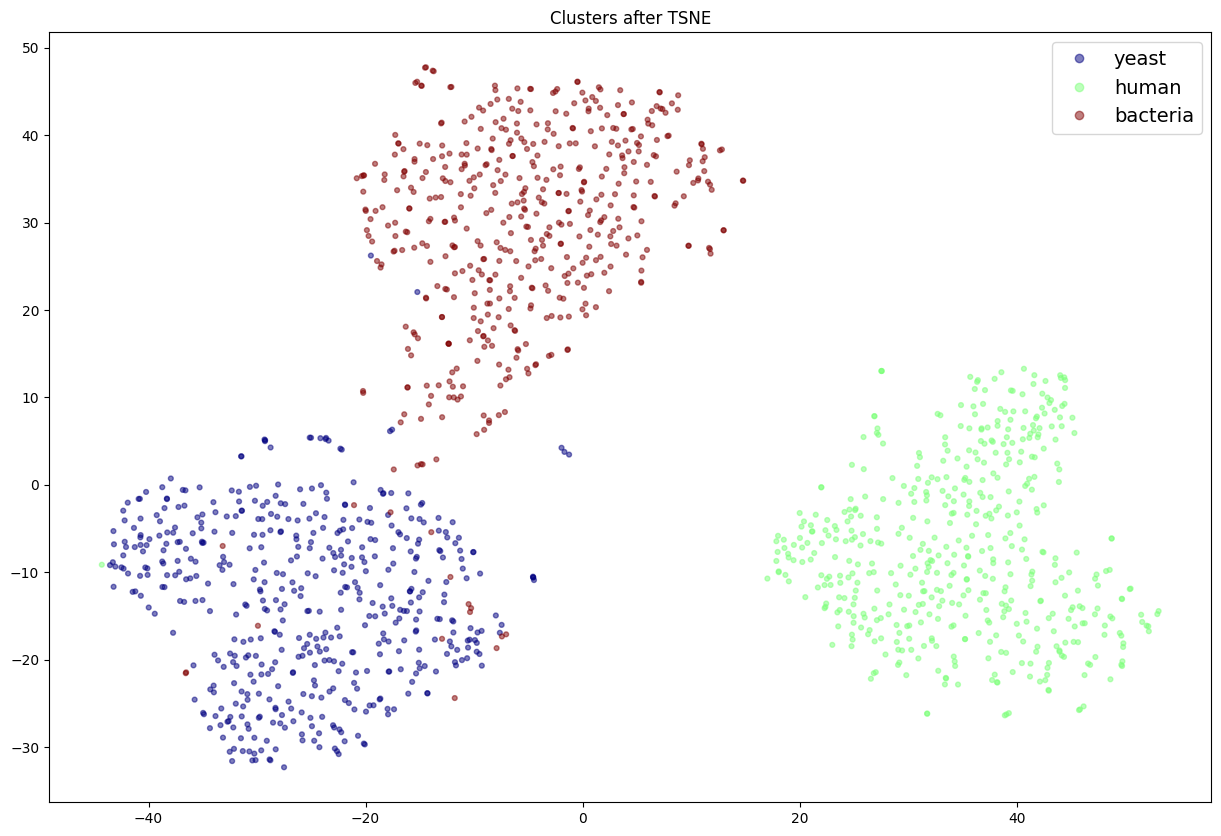

In [25]:
plt.clf()
fig = plt.figure(figsize=(15, 10))
s = plt.scatter(*all_embeddings_2d.T, c=species_labels, s=12, alpha=.5, cmap=mpl.colormaps['jet'])
plt.legend(s.legend_elements()[0], list(map(lambda n: n.split('_')[-1], needed_folders_names)), fontsize=14)
plt.title('Clusters after TSNE')
plt.savefig('clusters_tsne.pdf')
plt.show()

In [26]:
all_embeddings_2d_umap = UMAP(random_state=42).fit_transform(all_embeddings)

<Figure size 640x480 with 0 Axes>

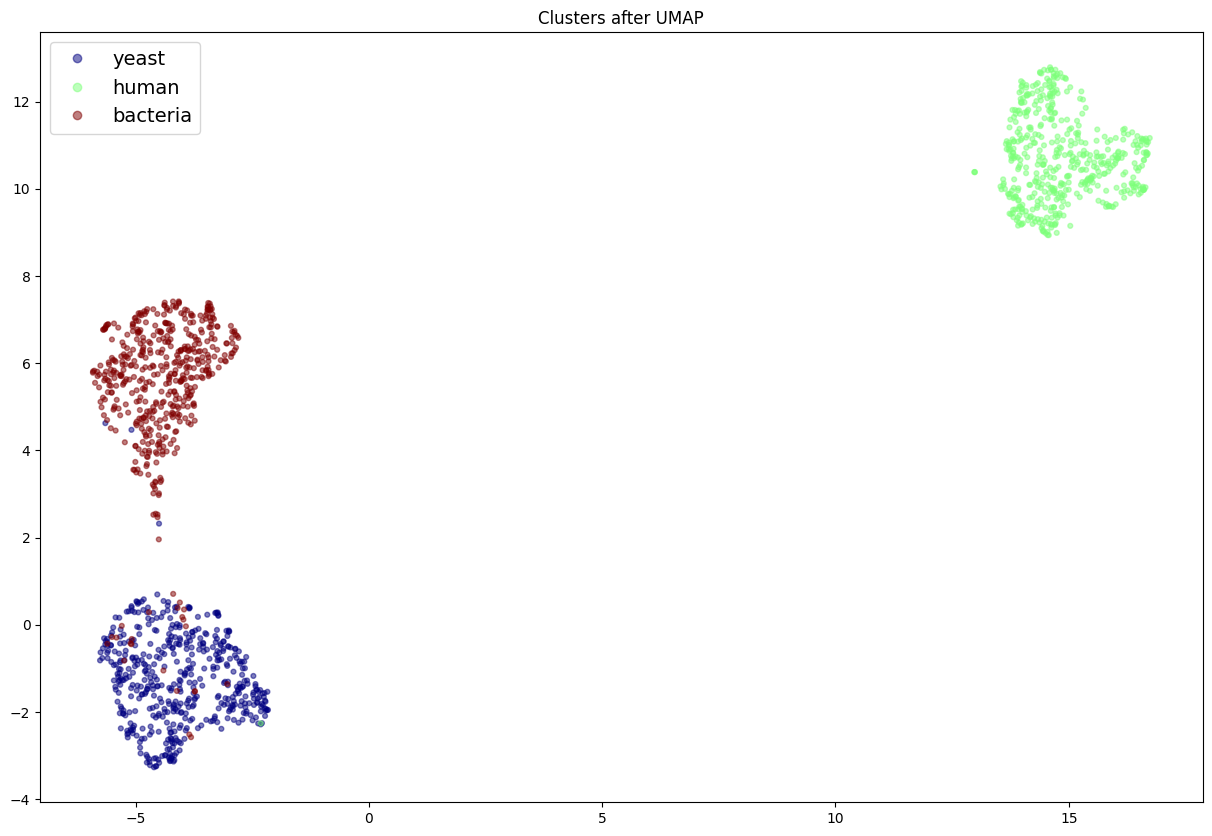

In [27]:
plt.clf()
fig = plt.figure(figsize=(15, 10))
s_umap = plt.scatter(*all_embeddings_2d_umap.T, c=species_labels, s=12, alpha=.5, cmap=mpl.colormaps['jet'])
plt.legend(s_umap.legend_elements()[0], list(map(lambda n: n.split('_')[-1], needed_folders_names)), fontsize=14)
plt.title('Clusters after UMAP')
plt.savefig('clusters_umap.pdf')
plt.show()